# Application of Maximum Entropy and Network Analysis

Alberto Chimenti - 1210360

In [1]:
import numpy as np
import scipy
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
import warnings
warnings.filterwarnings('ignore')

In [2]:
from IPython.display import display
#from tqdm import tqdm        #Library for update bar

%matplotlib inline
%precision 4

'%.4f'

In [45]:
def kde_hist(l, fig, ax, xlabel=None, title=None, reg=False, err=False, gauss=False, xlim=None, 
             label=None, color='#1f77b4', alpha=0.8, color_kde='#ffc17a'):
    #Calculating best binning using Friedmann-Driaconis rule
    iqr = np.subtract(*np.percentile(l, [75, 25]))
    h = 2 * iqr / (len(l)**(1/3))
    nbin = int((l.max() - l.min())/h)

    #Histogram
    ax.set_ylabel('Occurrences', fontsize=15)
    ax.set_xlabel(xlabel, fontsize=15)
    ax.set_title(title, fontsize=15)
    counts, bins, patches=ax.hist(l,bins=nbin, label=label, color=color, alpha=alpha)
    bin_centers = 0.5*(bins[1:] + bins[:-1])
    if err==True:
        ax.errorbar(bin_centers, counts, yerr=1/(np.sqrt(counts)),color='red', fmt='none', 
                    marker='.', capsize=5, label='Errorbars')

    #Gaussians
    stdev=1.06*np.std(l)*(l.size**(-1/5))
    points=np.linspace(min(l)-(max(l)/2),max(l)+(max(l)/2),len(l))
    gaussian=np.zeros((len(points),len(l)))
    for i in np.arange(len(l)):
        gaussian[i,:]=scipy.stats.norm.pdf(points,l[i],stdev)

    #Normalizing the KDE
    kde=np.sum(gaussian, axis=0)
    kde_int=scipy.integrate.trapz(kde, points)
    hist_int=scipy.integrate.trapz(counts, bin_centers)
    kde=kde*hist_int/kde_int
    ax.plot(points, kde, label='KDE '+str(label), color=color_kde, alpha=1)
    if gauss==True:
        ax.plot(points, scipy.stats.norm.pdf(points,-0.5,1)*110, label='Gaussian', alpha=0.8, color='#bfe3b4')
    if xlim!=None:
        plt.xlim(xlim)

    ax.grid()
    ax.legend(fontsize=12)

In [4]:
def ising_expected_values(s):
    return s.mean(axis=1), (s.sum(axis=0)**2).mean()/s.shape[0]

In [5]:
# Gradient descent algorithms
def gd(l, k, eta, grad):
    return l - eta*(grad[1:]), k - eta/len(l)*(grad[0])

def rms_prop(l, k, eta, grad, s_t, beta=0.9, epsilon=10**-8):
    s_t=beta*s_t + (1-beta)*(grad**2)
    l-=eta*np.divide((grad[1:]),np.sqrt(s_t[1:]+epsilon))
    k-=eta/len(l)*np.divide((grad[0]),np.sqrt(s_t[0]+epsilon))
    return l, k, s_t

def adam(l, k, eta, grad, s_t, m_t, i=1, beta_1=0.9, beta_2=0.99, epsilon=10**-8):
    m_t=beta_1*m_t + (1-beta_1)*(grad)
    s_t=beta_2*s_t + (1-beta_2)*(grad**2)
    m_hat=np.divide(m_t, (1-beta_1**(i+1)))
    s_hat=np.divide(s_t, (1-beta_2**(i+1)))
    l-=eta*np.divide((m_hat[1:]),np.sqrt(s_hat[1:]+epsilon))
    k-=eta/len(l)*np.divide((m_hat[0]),np.sqrt(s_hat[0]+epsilon))
    return l, k, s_t, m_t

In [6]:
#Metropolis simulation
def metropolis_ising(l, k, n_samples, max_iter=4000, n_part=299):
    
    Energy=[]
    s=pd.DataFrame(index=np.arange(n_part))
    #Generate random configuration
    s_test=2*np.random.randint(0,2, n_part)-1
    E = -(k/n_part)*(np.sum(s_test)**2)-np.sum(l*s_test)
    Energy.append(E)
    
    #"Thermalization" steps
    for i in np.arange(max_iter):
        index=np.random.randint(0, n_part)
        s_test[index]*=-1  #Random flip
        dE=-2*l[index]*s_test[index] + 4*(k/n_part)*s_test[index]*(s_test[index]-sum(s_test))
        p=min([1,np.exp(-dE)])
        y=np.random.uniform(0,2) #Random estraction
        if y>p:
            s_test[index]*=-1 #go back to previous configuration
        else:
            E+=dE
        Energy.append(E)

    #Useful samples
    for i in np.arange(n_samples):
        index=np.random.randint(0, n_part)
        s_test[index]*=-1  #Random flip
        dE=-2*l[index]*s_test[index] + 4*(k/n_part)*s_test[index]*(s_test[index]-sum(s_test))
        p=min([1,np.exp(-dE)])
        y=np.random.uniform(0,2)
        if y>p:
            s_test[index]*=-1 #go back to previous configuration
        else:
            E+=dE
        Energy.append(E)
        s[str(i)]=s_test
    m_sim, m_2_sim=ising_expected_values(s)
    return m_sim, m_2_sim, Energy
    

def metrop_gd(m, m_2, eta, iterations=500, n_samples=400, max_iter=4000, verb=0, method='gd'):
    l_test=np.random.randn(299) - 0.5 #Generate lambdas from gaussian distribution
    k_test=np.random.rand() #Select a random value ranging the lambdas
    
    w=np.zeros((300,iterations))
    E=np.zeros((max_iter+n_samples+1, iterations))
    
    #Gradient descent parameters
    grad=np.zeros((300,iterations))
    grad_mean=np.zeros((2,iterations))
    s_t=np.zeros((300))
    m_t=np.zeros((300))
    
    #pbar=tqdm(total=iterations) #update bar...
    for i in np.arange(iterations):
        m_sim, m_2_sim, Energy = metropolis_ising(l=l_test, k=k_test, n_samples=n_samples, max_iter=max_iter)
        
        # Storing values
        w[0,i]=k_test
        w[1:,i]=l_test
        E[:,i]=Energy
        
        if verb!=0 and i%verb==0:
            print('----------------------------')
            print('Iteration '+str(i)+' parameters update')
            print('Simulation value k='+str(k_test))
            print('Empirical <(Σσ)^2>='+str(m_2)+' Simulation <(Σσ)^2>='+str(m_2_sim))
            print('Avarage difference <(<σ_model>-<σ_emp>)>='+str(np.mean(m_sim.values - m.values)))
        
        # "Stocastic Gradient"
        grad[0,i]=m_2_sim - m_2
        grad[1:,i]=m_sim.values - m.values
        grad_mean[0,i]=grad[0,i]
        grad_mean[1,i]=np.mean(grad[1:,i])
        
        # Updating parameters
        if method=='gd':
            l_test, k_test = gd(l_test, k_test, eta, grad[:,i]) #GRADIENT DESCENT
        elif method=='rms':
            l_test, k_test, s_t = rms_prop(l_test, k_test, eta, grad[:,i], s_t) #RMS-PROPAGATION
        elif method=='adam':
            l_test, k_test, s_t, m_t = adam(l_test, k_test, eta, grad[:,i], s_t, m_t, i) #ADAM
        #pbar.update(1)
    
    #pbar.close() 
    return w, E, grad_mean

In [7]:
#Network analisys
def laplacian_matrix(M):
    return np.diag(np.sum(M.values, axis=1)) - M

def conn_comp(M):
    L=laplacian_matrix(M)
    eig=np.linalg.eigvals(L)
    return np.sum(np.abs(eig)<1e-10) #not using ==0 to take into account algorithm approximation

In [8]:
#Plotting distributions from graph object
def plot_degree_dist(G, fig=None, ax=None, degrees=None, title=None, label=None, err=True, 
                     color='#1f77b4', color_kde='#ffc17a'):
    try:
        if degrees==None:
            degrees = np.asarray([G.degree(n) for n in G.nodes()])
    except ValueError:
        pass
    if fig==None and ax==None:
        fig, ax=plt.subplots(nrows=1, ncols=1, figsize=(10,5))
    kde_hist(degrees, fig, ax, xlabel='Nodes degree', title=title, err=err, label=label, 
            color=color, color_kde=color_kde)
    return degrees
    
def plot_clust_dist(G, fig=None, ax=None, clust=None, title=None, label=None, err=True, 
                   color='#1f77b4', color_kde='#ffc17a'):
    try:
        if clust==None:
            clust = np.array(list(nx.clustering(G).values()))
    except ValueError:
        pass
    if fig==None and ax==None:
        fig, ax=plt.subplots(nrows=1, ncols=1, figsize=(10,5))
    kde_hist(clust, fig, ax, xlabel='Clustering coefficient', title=title, err=err, label=label,
            color=color, color_kde=color_kde)
    return clust

# 1. Data extraction and presentation

The dataset repots 299 different spieces


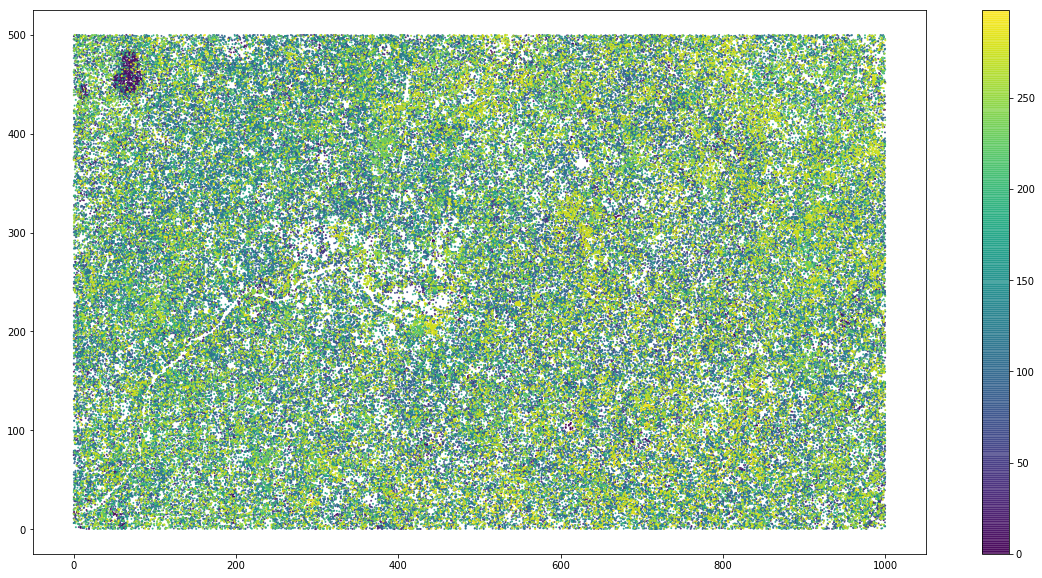

In [9]:
#Load the data
data = pd.read_csv("bci05.csv")
data = data[data['status']=='A']  #Selecting alive species
data.drop(['status','tag','dbh', 'date', 'codes','pom'],axis=1, inplace=True)
nspieces=len(data.groupby(data['sp']).size()) #Number of species
print('The dataset repots %d different spieces'%nspieces)

#Visualization
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
col_grade=label_encoder.fit_transform(data['sp']) #Color grading for each specie
fig=plt.figure(figsize=(20,10))
plot=plt.scatter(data['gx'], data['gy'], c=col_grade, alpha=0.8, s=1)
plt.colorbar(plot)
fig.savefig('images\Forest_plot.png')
plt.show()

# 2. Sub-plot division

In [10]:
#Data separation
groups=np.zeros(len(data))
l=0
for i in np.arange(20):
    mask1 = np.logical_and(data['gx']>=((50)*(i)), data['gx']<=((50)*(i+1)))
    for j in np.arange(10):
        mask2 = np.logical_and(data['gy']>=(50*j), data['gy']<=(50*(j+1)))
        mask = np.logical_and(mask1,mask2)
        groups[mask]= l
        l+=1
data['groups']=groups

#Abundancies of each specie
temp=data.groupby(['groups','sp']).size() #Pandas Series with the different species population divided in subplots
ab=pd.DataFrame(columns=data['sp'].unique()) #Dataframe init
for i in np.arange(200):
    ab=ab.append([temp[i]]) #Appending subplot population matching column indexes
ab.fillna(0, inplace=True)
ab.index=np.arange(200)
ab=ab.T

print('Matrix of the abundances for all the species in all subplots: (shape=',ab.shape,')')
display(ab.head())

#Avarage "presence"
p=ab.copy()
p[p!=0]=1
print('Average “presence” p_i of each species:')
display(p.mean(axis=1).head())

Matrix of the abundances for all the species in all subplots: (shape= (299, 200) )


,0,1,2,3,4,5,6,7,8,9,...,190,191,192,193,194,195,196,197,198,199
ACACME,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
ACALDI,25,1,0,0,1,1,1,0,2,4,...,0,0,1,1,8,3,3,2,3,6
ACALMA,9,0,0,0,1,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
ADE1TR,0,0,0,1,12,2,5,0,0,0,...,3,0,0,1,7,0,0,0,0,0
AEGIPA,0,1,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Average “presence” p_i of each species:


ACACME    0.050
ACALDI    0.765
ACALMA    0.080
ADE1TR    0.275
AEGIPA    0.180
dtype: float64

# 3. Max Ent 1

We build a max ent model

$$
\begin{equation}{
    Z=\sum_{\{\sigma_{i}\}=-1,1}e^{-\sum_{i=1}^{N_{species}}\lambda_{i}\sigma_{i}}=
        \prod_{i=1}^{N_{species}}\sum_{\{\sigma_{i}\}=-1,1}e^{-\lambda_{i}\sigma_{i}}=
        \prod_{i=1}^{N_{species}}(e^{-\lambda_{i}} + e^{\lambda_{i}})=2^{N_{species}}\prod_{i=1}^{N_{species}}cosh(\lambda_{i})
}\end{equation}
$$

Therefore we impose that that:
$$
\begin{equation}{
    <\sigma_{i}>_{emp}=<\sigma_{i}>_{model}=-\frac{1}{Z}\frac{\partial Z}{\partial\lambda_{i}}=tanh(\lambda_{i})
}\end{equation}
$$

And then!!!

$$
\begin{equation}{
    \lambda_{i}\simeq tanh^{-1}(<\sigma_{i}>_{emp})
}\end{equation}
$$

The following species are present in every subplot: 
 ['ALSEBL', 'DES2PA', 'FARAOC', 'GAR2IN', 'HIRTTR', 'HYBAPR', 'MOURMY', 'TET2PA', 'TRI2TU'] 



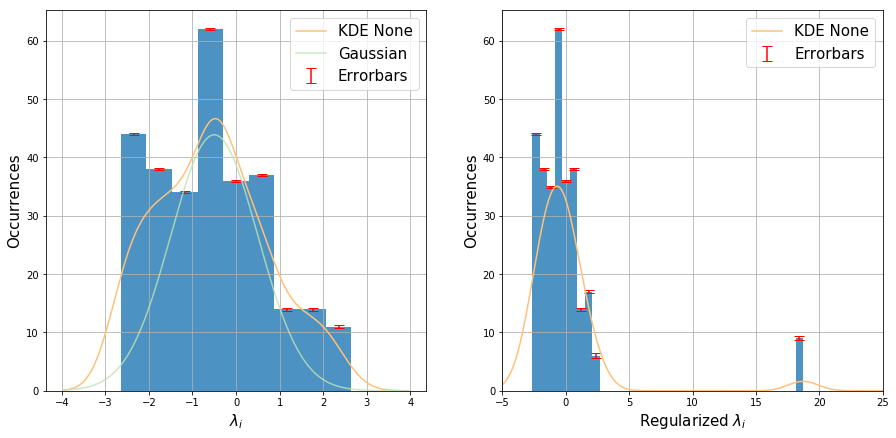

In [11]:
reg=1e-16 #Regularization term, avoids infinite values

s_emp=2*(p)-1
l=np.arctanh(s_emp.mean(axis=1)) #Lagrange parameters
l_reg=np.arctanh(s_emp.mean(axis=1)-reg) #Regularized ones

#Evaluating "Ever_Present Species"
ever_present=np.asarray(l[(l==np.inf)].index)
print('The following species are present in every subplot: \n',list(ever_present), '\n')

#Plots
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15,7))
kde_hist(l.drop(ever_present), fig, ax[0], xlabel='$\lambda_{i}$', gauss=True, err=True)
kde_hist(l_reg, fig, ax[1], xlabel='Regularized $\lambda_{i}$', reg=True, xlim=(-5,25), err=True)
fig.savefig('images\lambdas_distribution.png')

# 4. Max Ent 2

We build the model using the following hamiltonian:

$$
\begin{equation}{
    \mathcal{H}=-\lambda_{0}\Big(\sum_{i=1}^{N_{species}}\sigma_{i}\Big)^{2} - \sum_{i=1}^{N_{species}}\lambda_{i}\sigma_{i}
}\end{equation}
$$

--> Generate random Lagrange multipliers

--> Generate a random spin configuration for the 299 species (+1/-1)

--> Then flip one spin and calculate the energy difference between the old and new state as:

$$
\begin{equation}{
    \mathcal{H}'-\mathcal{H}=-2\lambda_{k}\sigma_{k}' + 4\lambda_{0}\sigma_{k}'[\sigma_{k}'-(s_++s_-)_{new}]
}\end{equation}
$$

--> If the energy diff is negative i accept the step, if it is negative i flip a coin and confront the result with the boltzmann probability associated with the energy diff and decide wether accept or not the step

--> Iterate this process $\simeq 10^{6}$ times in order to reach the equilibrium and save the last $\simeq 10^{3/4}$ iteration configurations

--> Get the mean for the various spin along the fluctuations and update the $\lambda$ values using:

$$
\begin{equation}{
    \lambda_{i} \rightarrow \lambda_{i} + \eta(<\sigma_{i}>_{model} - <\sigma_{i}>_{emp})
}\end{equation}
$$$$
\begin{equation}{
    \lambda_{0} \rightarrow \lambda_{0} + \eta(<\sigma_{i}^{2}>_{model} - <\sigma_{i}^{2}>_{emp})
}\end{equation}
$$

--> Reitarate the process $\simeq 300$ times

In [12]:
#Best fit eta=0.05

np.random.seed(5678435)

iterations=201
verb=100
values=[0.3, 0.05]
method='adam'
best_index=np.zeros((len(values)), dtype='int')
grad=np.zeros((2,iterations,len(values)))

m, m_2=ising_expected_values(s_emp)
w=np.zeros((len(values),300,iterations))

for i, eta in enumerate(values):
    print('\n ---> Iteration with eta='+str(eta)+', method='+str(method))
    w[i,:,:], E, grad[:,:,i]=metrop_gd(m, m_2, eta, iterations=iterations, verb=verb, method=method)
    best_index[i]=np.argmin(np.abs(grad[0,:,i]) + np.abs(grad[1,:,i]))


 ---> Iteration with eta=0.3, method=adam
----------------------------
Iteration 0 parameters update
Simulation value k=0.7514984859106473
Empirical <(Σσ)^2>=21.32829431438127 Simulation <(Σσ)^2>=188.94555183946488
Avarage difference <(<σ_model>-<σ_emp>)>=-0.5369565217391304
----------------------------
Iteration 100 parameters update
Simulation value k=0.7390586726598425
Empirical <(Σσ)^2>=21.32829431438127 Simulation <(Σσ)^2>=11.890903010033446
Avarage difference <(<σ_model>-<σ_emp>)>=0.061956521739130445
----------------------------
Iteration 200 parameters update
Simulation value k=0.7427951617751114
Empirical <(Σσ)^2>=21.32829431438127 Simulation <(Σσ)^2>=24.619397993311036
Avarage difference <(<σ_model>-<σ_emp>)>=-0.028478260869565206

 ---> Iteration with eta=0.05, method=adam
----------------------------
Iteration 0 parameters update
Simulation value k=0.6871978568361833
Empirical <(Σσ)^2>=21.32829431438127 Simulation <(Σσ)^2>=188.99719063545152
Avarage difference <(<σ_model>-

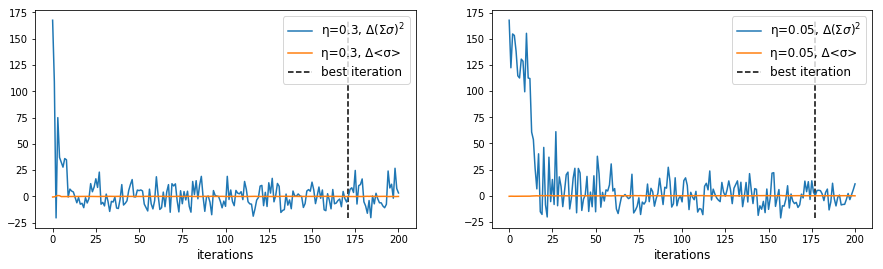

Best value for 171th iteration k=0.7424164837568652 with η=0.3
Best value for 177th iteration k=0.6823775755533636 with η=0.05


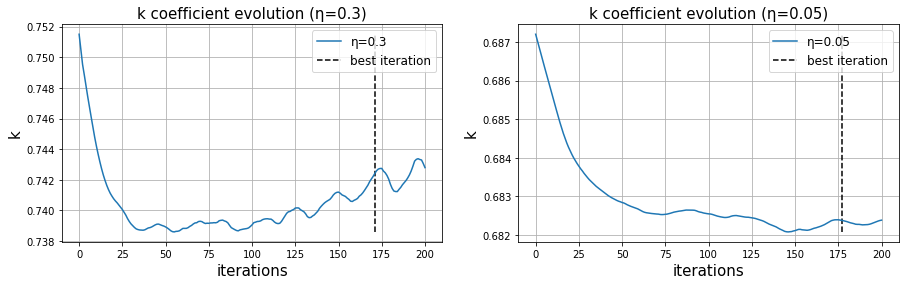

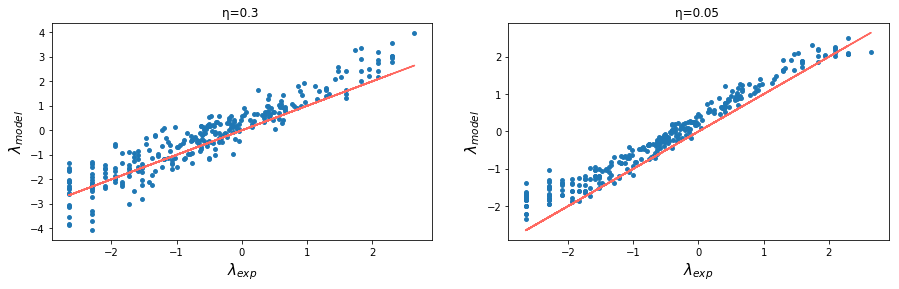

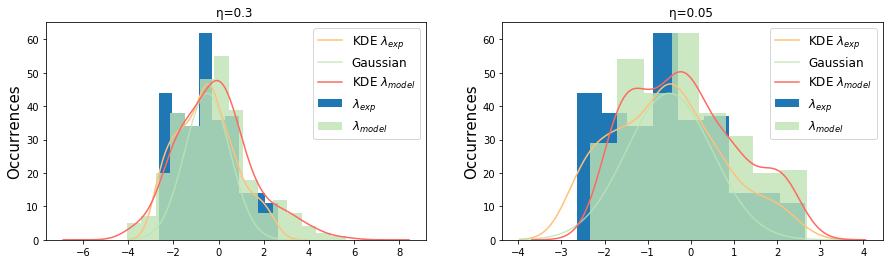

In [49]:
#Gradients
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15,4))
for i, eta in enumerate(values):
    ax[i].plot(grad[0,:,i], label=('η='+str(eta)+', $Δ(Σσ)^2$'))
    ax[i].plot(grad[1,:,i], label=('η='+str(eta)+', Δ<σ>'))
    ax[i].vlines(best_index[i], np.min(grad[0,:,i]), np.max(grad[0,:,i]), 
                 label='best iteration', linestyle='dashed')
    ax[i].set_xlabel('iterations', fontsize=12)
    ax[i].legend(fontsize=12)
extent = ax[1].get_window_extent().transformed(fig.dpi_scale_trans.inverted())
fig.savefig('images\sim_constraint_evolution.png', bbox_inches=extent.expanded(1.3, 1.4))
plt.show()

#k coefficient
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15,4))
for i, val in enumerate(values):
    ax[i].plot(w[i,0,:], label=('η='+str(val)))
    ax[i].vlines(best_index[i], np.min(w[i,0,:]), np.max(w[i,0,:]), label='best iteration', linestyle='dashed')
    ax[i].set_title('k coefficient evolution (η='+str(val)+')', fontsize=15)
    ax[i].set_xlabel('iterations', fontsize=15)
    ax[i].set_ylabel('k', fontsize=15)
    ax[i].legend(fontsize=12)
    ax[i].grid()
    print('Best value for '+str(best_index[i])+'th iteration k='+str(w[i,0,best_index[i]])+' with η='+str(val))
extent = ax[1].get_window_extent().transformed(fig.dpi_scale_trans.inverted())
fig.savefig('images\sim_k_evolution.png', bbox_inches=extent.expanded(1.3, 1.4))
plt.show()


#Lambdas
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15,4))
for i, val in enumerate(values):
    ax[i].scatter(l, w[i,1:,best_index[i]], s=15)
    ax[i].set_title('η='+str(val)+' ')
    ax[i].set_xlabel('$\lambda_{exp}$', fontsize=15)
    ax[i].set_ylabel('$\lambda_{model}$', fontsize=15)
    ax[i].plot(l,l, '#ff6961')
extent = ax[1].get_window_extent().transformed(fig.dpi_scale_trans.inverted())
fig.savefig('images\sim_lambdas.png', bbox_inches=extent.expanded(1.3, 1.4))
plt.show()

#Lambdas
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15,4))
for i, val in enumerate(values):
    kde_hist(l.drop(ever_present), fig, ax[i], label='$\lambda_{exp}$', gauss=True, alpha=1)
    kde_hist(w[i,1:,best_index[i]], fig, ax[i], label='$\lambda_{model}$', color='#bfe3b4', color_kde='#ff6961', alpha=0.8)
    ax[i].set_title('η='+str(val)+' ')
extent = ax[1].get_window_extent().transformed(fig.dpi_scale_trans.inverted())
#fig.savefig('images\sim_lambdas.png', bbox_inches=extent.expanded(1.3, 1.4))
plt.show()

Best learning rate: 0.05


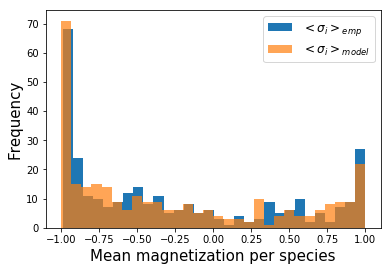

k value for best iteration: 0.6823775755533636
λ mean value for best iteration: -0.1254275336960087
λ std: 1.2357791685651995
Empirical constraint <(Σσ)^2>: 21.32829431438127
Best simulation result <(Σσ)^2>: 21.38180602006689
Empirical constraint <σ>: -0.2579598662207357
Best simulation result <σ>: -0.2669565217391303


In [14]:
#Final estimation
best_model=np.argmin([(np.abs(grad[0,best_index[0],0]) + np.abs(grad[1,best_index[0],0])), 
                      (np.abs(grad[0,best_index[1],1]) + np.abs(grad[1,best_index[1],1]))])
print('Best learning rate: '+str(values[best_model]))

#Confront with simulated magnetization
m_sim,m_2_sim,_=metropolis_ising(w[best_model,1:,best_index[best_model]], 
                           w[best_model,0,best_index[best_model]], n_samples=20000)
fig=plt.figure(); ax=plt.axes()
plt.hist(m, bins=30, label='$<σ_{i}>_{emp}$')
plt.hist(m_sim, bins=30, alpha=0.7, label='$<σ_{i}>_{model}$')
ax.set_xlabel('Mean magnetization per species', fontsize=15)
ax.set_ylabel('Frequency', fontsize=15)
plt.legend(fontsize=12)
fig.savefig('images\sim_magnetization.png')
plt.show()

#Simulation results
print('k value for best iteration:', w[best_model,0,best_index[best_model]])
print('λ mean value for best iteration:', np.mean(w[best_model,1:,best_index[best_model]]))
print('λ std:', np.std(w[best_model,1:,best_index[best_model]]))
print('Empirical constraint <(Σσ)^2>:', m_2)
print('Best simulation result <(Σσ)^2>:', grad[0,best_index[best_model],best_model] + m_2)
print('Empirical constraint <σ>:', np.mean(m))
print('Best simulation result <σ>:', grad[1,best_index[best_model],best_model] + np.mean(m))

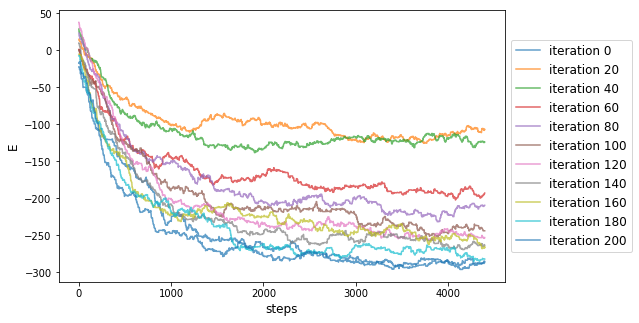

In [25]:
#Energies example
fig=plt.figure(figsize=(10,5)); ax=plt.axes()
for i in np.arange(int(iterations/20)+1):
    plt.plot(E[:, i*20-1], alpha=0.7, label=('iteration '+str(i*20)))
    box = ax.get_position()
    
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5),fontsize=12) 
ax.set_xlabel('steps',fontsize=12)
ax.set_ylabel('E',fontsize=12)
fig.savefig('images\energy.png')
plt.show()

# 5. Phase diagram

$$ 
\begin{equation}{
2 \hat{J}(\hat{\beta})=\int \frac{dz}{\sqrt{2\pi} \sigma} \exp\left(-\frac{z^2}{2\hat{\sigma}^2}\right) \frac{1}{\left(\cosh(z)\right)^2}
}\end{equation}
$$

In [26]:
def phase_diagram(sigma):
    integral= lambda x: np.exp(-(x**2)/(2*sigma**2))/(np.sqrt(2*np.pi)*sigma*(np.cosh(x))**2)
    J=1/(2*scipy.integrate.quad(integral, -np.inf, np.inf)[0])
    return J

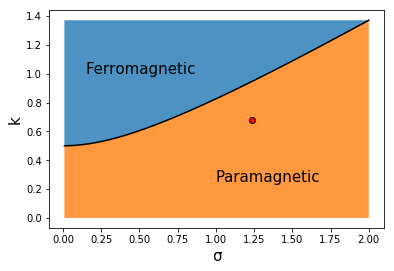

In [27]:
sigmas=np.linspace(0.01,2, 1000)
k=np.zeros(1000)
for i in np.arange(1000):
    k[i]=phase_diagram(sigmas[i])
fig=plt.figure(); ax=plt.axes()
ax.plot(sigmas,k, color='black')
ax.fill_between(sigmas, k, np.max(k), alpha=0.8)
ax.fill_between(sigmas, 0, k, alpha=0.8)
plt.text(0.15, 1, 'Ferromagnetic',fontsize=15)
plt.text(1, 0.25, 'Paramagnetic',fontsize=15)
ax.set_xlabel('σ', fontsize=15)
ax.set_ylabel('k', fontsize=15)
ax.scatter(np.std(w[best_model,1:,best_index[best_model]]), w[best_model,0,best_index[best_model]], color='red', edgecolors='black')
fig.savefig('images\phase_diagram.png')
plt.show()

# 6. Max Ent 3

Build the model using the following Hamiltonian:

$$
\begin{equation}{
    \mathcal{H}=\frac{1}{2}\sum_{i,j=1}^{S'}M_{ij}x_{i}x_{j} + \sum_{i=1}^{S'}\lambda_{i}x_{i}
}\end{equation}
$$

By imposing the constraints:
$$
\begin{equation}{
<x_{i}>_{emp}=<x_{i}>_{model} \;\;\;\;\; (1)
}\end{equation}
$$
$$
\begin{equation}{
<x_{i}x_{j}>_{emp}=<x_{i}x_{j}>_{model} \;\;\;\;\; (2)
}\end{equation}
$$

We find that:

$$
\begin{equation}{
Z=\int_{\mathcal{R}^S}(dx)^{S} e^{-\mathcal{H}}=\frac{(2\pi)^{-\frac{S}{2}}}{|M|^{\frac{1}{2}}}e^{\frac{1}{2}\boldsymbol{\lambda}^{T}\boldsymbol{M}\boldsymbol{\lambda}}
}\end{equation}
$$

Using: 
$$
\begin{equation}{
(1) \;\;\;\;\; <x_{i}>_{emp}=-\frac{\partial}{\partial \lambda_{i}}lnZ \;\;\; \Rightarrow \;\;\; <x_{i}>_{emp}=-\sum_{j=1}^{S'}M_{ij}^{-1}\lambda_{j}
}\end{equation}
$$

$$
\begin{equation}{
(2) \;\;\;\;\; \frac{\partial^{2}Z}{\partial\lambda_{i}\partial\lambda_{j}}=M_{ij}^{-1}=<x_{i}x_{j}>_{emp} -<x_{i}>_{emp}<x_{j}>_{emp}=Cov(x_{i},x_{j})
}\end{equation}
$$



$$
\begin{equation}{
\;\;\;\;\; \Rightarrow \;\;\;\;\; <(x_{i}-<x_{i}>_{emp})(x_{j}-<x_{j}>_{emp})>_{emp}=Cov(x_{i},x_{j})=M_{ij}^{-1}
}\end{equation}
$$

In [28]:
x=ab.mean(axis=1) #mean abundances
std=ab.std(axis=1) #std abundances

#Filtering the distribution
mask=x>std
ab=ab.drop((x[np.logical_not(mask)].index.values), axis='index').transpose()
x=x[mask]

The number of species respecting the threshold is: 52


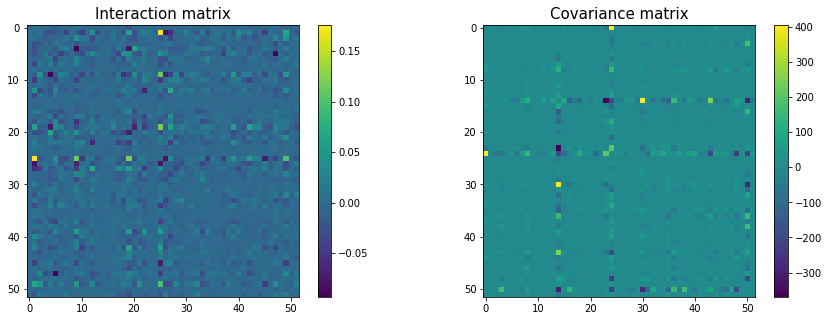

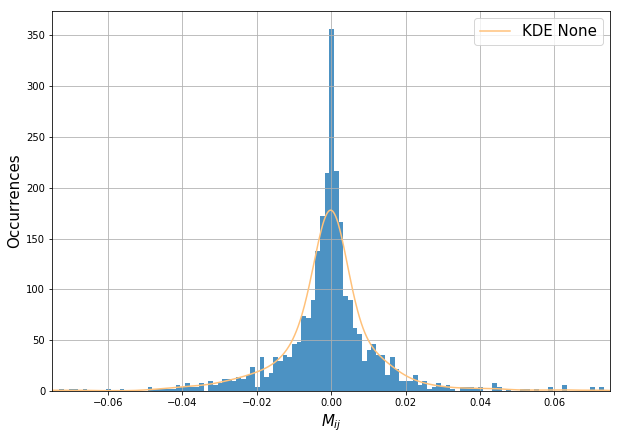

In [29]:
C=ab.cov() #Covariance matrix
M=pd.DataFrame(np.linalg.inv(C), columns=ab.columns, index=ab.columns) #Interaction matrix

#Setting diag to zero
for i in M.columns:
    M.loc[i,i]=0
    C.loc[i,i]=0

u=-np.dot(M, x)

#Visualization
print('The number of species respecting the threshold is: '+str(M.shape[0]))

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15,5))
im1=ax[0].imshow(M)
ax[0].set_title('Interaction matrix', fontsize=15)
fig.colorbar(im1, ax=ax[0])
im2=ax[1].imshow(C)
ax[1].set_title('Covariance matrix', fontsize=15)
fig.colorbar(im2, ax=ax[1])
extent = ax[0].get_window_extent().transformed(fig.dpi_scale_trans.inverted())
fig.savefig('images\interaction_matrix.png', bbox_inches=extent.expanded(1.5, 1.2))
plt.show()
fig1, ax1=plt.subplots(nrows=1,ncols=1, figsize=(10,7))
ax1.set_title('Interaction coefficient distribution', fontsize=15)
kde_hist(M.values.flatten(), fig1, ax1, xlabel='$M_{ij}$', err=False, xlim=(-0.075,0.075))
fig1.savefig('images\M_distribution.png')

# 7. Graph

We build a model using the $M_{ij}$ as adjacency matrix of the graph.

Defining the Laplacian matrix as:
$$
\begin{equation}{
L=K-A
}\end{equation}
$$

We know that for each connected component it will have one eigenvalue equal to 0.

-->We impose a threshold on the values of the adjacency matrix and calculate the Laplacian eigenvalues and reiterate until L has just one zero eigenvalue.

-->Use the M found as an ajacency matrix to build the graph

Single connected component threshold θ*=0.0030978225301829736


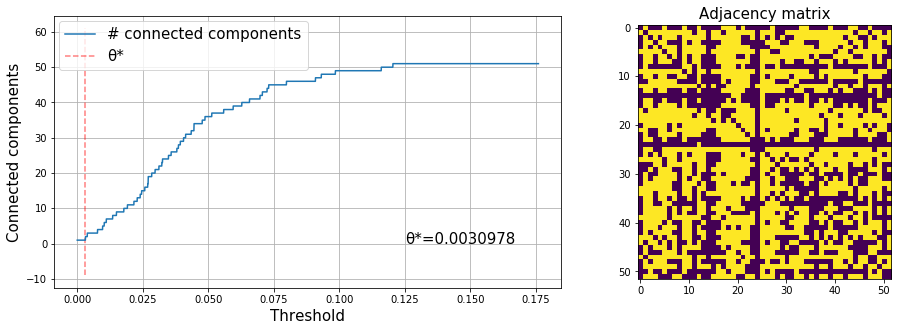

In [62]:
#Finding Threshold
thresholds=np.linspace(0,np.max(np.abs(M.values)), 10e3) #Threshold spectrum
ccomp=np.zeros(len(thresholds)) #Connected components vector

for i, thr in enumerate(thresholds):
    temp=M.copy()
    temp[np.abs(temp)<thr]=0 #Imposing threshold 
    ccomp[i]=conn_comp(temp) #Computes the number of connected components

th_star=thresholds[np.max(np.where(ccomp==1))] #Maximum threshold for single connected component

#Adjacency matrix
adj=M.copy()
adj[np.abs(adj)<th_star]=0
adj[~(np.abs(adj)<th_star)]=1
    
print('Single connected component threshold θ*='+str(th_star))

#Visualization
fig, ax = plt.subplots(nrows=1, ncols=2, gridspec_kw = {'width_ratios':[2, 1]}, figsize=(15,5))
ax[0].plot(thresholds, ccomp, label='# connected components')
ax[0].vlines(th_star, np.min(ccomp)-10, np.max(ccomp)+10, label='θ*', linestyle='dashed', alpha=0.5, color='red')
ax[0].set_xlabel('Threshold', fontsize=15)
ax[0].set_ylabel('Connected components', fontsize=15)
ax[0].text(0.125, 0, ('θ*=%.7f'%th_star),fontsize=15)
ax[0].legend(fontsize=15, loc=(0.01,0.8))
ax[0].grid()

ax[1].imshow(adj)
ax[1].set_title('Adjacency matrix', fontsize=15)
fig.savefig('images\Thresholds.png')
plt.show()

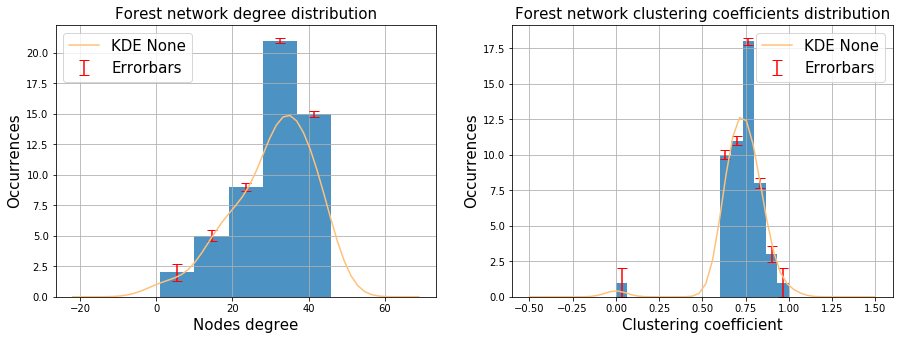


FOREST NETWORK: 

Diameter of the graph: 3
Mean degree value: 30.423076923076923
Mean clustering coefficient 0.7286928579038091
Degree assortativity coefficient: -0.24068412868609207
Mean betweenness centrality: 0.008205128205128205

ERDOS-RENYI RANDOM GRAPH: 

Diameter of the graph: 2
Mean degree value: 30.55384615384615
Mean clustering coefficient 0.598814533431981
Degree assortativity coefficient: -0.046595166138278535
Mean betweenness centrality: 0.008018099547511313


In [31]:
#Create the network object
G=nx.from_numpy_matrix(adj.values)

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15,5))
degrees = plot_degree_dist(G, fig, ax[0], title='Forest network degree distribution') #Degree distribution
clust = plot_clust_dist(G, fig, ax[1], title='Forest network clustering coefficients distribution') #Clustering coefficients distribution
fig.savefig('images\Forest_network_distributions.png')
plt.show()
centrality=np.array(list(nx.betweenness_centrality(G).values())) #Betweenness centrality
print('\nFOREST NETWORK: \n')
print('Diameter of the graph:', str(nx.diameter(G)))
print('Mean degree value:', str(np.mean(degrees)))
print('Mean clustering coefficient', str(np.mean(clust)))
print('Degree assortativity coefficient:', str(nx.degree_assortativity_coefficient(G)))
print('Mean betweenness centrality:', str(np.mean(centrality)))

#Erdos-Renyi graph
n_samples=10
degrees_er=np.zeros((adj.shape[0], n_samples))
clust_er=np.zeros((adj.shape[0], n_samples))
centrality_er=np.zeros((adj.shape[0], n_samples))
diam_er=0
ass_coeff=0
p=np.mean(degrees)/(adj.shape[0]-1)
for i in np.arange(n_samples):
    G_er=nx.erdos_renyi_graph(adj.shape[0], p)
    degrees_er[:,i] = np.asarray([G_er.degree(n) for n in G_er.nodes()]) #Degree distribution
    clust_er[:,i] = np.array(list(nx.clustering(G_er).values())) #Clustering coefficients distribution
    centrality_er[:,i]=np.array(list(nx.betweenness_centrality(G_er).values())) #Betweenness centrality
    diam_er+=nx.diameter(G_er)
    ass_coeff+=nx.degree_assortativity_coefficient(G_er)
degrees_er=np.mean(degrees_er, axis=1)
clust_er=np.mean(clust_er, axis=1)
centrality_er=np.mean(centrality_er, axis=1)

print('\nERDOS-RENYI RANDOM GRAPH: \n')

print('Diameter of the graph:', str(int(diam_er/n_samples)))
print('Mean degree value:', str(np.mean(degrees_er)))
print('Mean clustering coefficient', str(np.mean(clust_er)))
print('Degree assortativity coefficient:', str(ass_coeff/n_samples))
print('Mean betweenness centrality:', str(np.mean(centrality_er)))

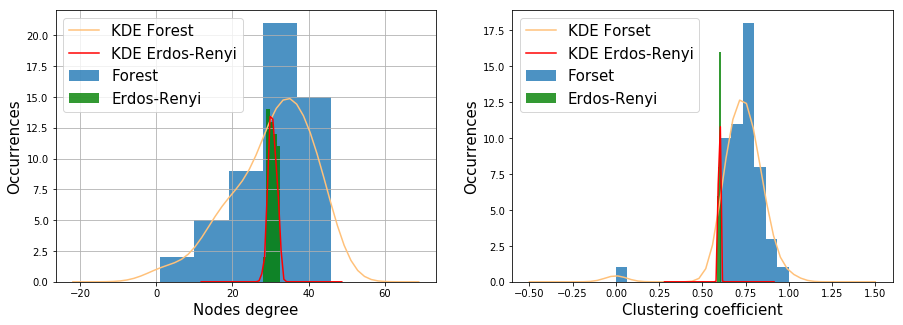

In [32]:
#Confrontation
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15,5))
plot_degree_dist(G, fig, ax[0], label='Forest', degrees=degrees, err=False)
plot_degree_dist(G, fig, ax[0], label='Erdos-Renyi', degrees=degrees_er, err=False, color='green', color_kde='red')

plot_clust_dist(G, fig, ax[1], label='Forset', clust=clust, err=False)
plot_clust_dist(G, fig, ax[1], label='Erdos-Renyi', clust=clust_er, err=False, color='green', color_kde='red')
ax[0].grid() 
ax[1].grid()
fig.savefig('images\confrontation_network_distributions.png')
plt.show()